# Broadcast

## But : Faire un broadcast, départ décalé 


### Informations générales

#### Le nom de l'expérience : Nom du folder contenant les fichiers sources et résultats

In [1]:
experiment_name = "Time_Bcast"
crashed = True

#### Versions

In [2]:
%%bash -s
git log -n 1
python3 --version
R --version

commit d1b8c507b9b76e1bd27c35dbda152f27f27b9fdc
Author: Najwa Ez Zine <nezzine@fnancy>
Date:   Tue Jul 10 13:43:47 2018 +0200

    Automatic results update : Time_Bcast --- None Fix : ggplot2 value
Python 3.5.3
R version 3.3.3 (2017-03-06) -- "Another Canoe"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



### Préparation de l'environnement (FRONTEND)

#### Installation des modules

In [3]:
%%bash -s
pip3 install --user execo
pip3 install --user requests

# Permet affichage pllus lisible avec couleurs
pip3 install --user termcolor

# Permettent d'utiliser R :
pip3 install --user rpy2
pip3 install --user tzlocal

  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7c/e6/92ad559b7192d846975fc916b65f667c7b8c3a32bea7372340bfe9a15fa5/certifi-2018.4.16-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/c9/6fdd990019071a4a32a5e7cb78a1d92c53851ef4f56f62a3486e6a7d8ffb/urllib3-1.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/ff/ae64bacdfc95f27a016a7bed8e8686763ba4d277a78ca76f32659220a731/Jinja2-2.10-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b

#### Chargement des modules dans l'environnement

In [4]:
import execo
import math
import collections
import os
import sys
import json
import time
import random
import datetime
import re
import tzlocal

from execo import *
from execo_g5k import *
from execo_engine import *

from shutil import copy
from subprocess import check_output

from threading import Thread

from collections import deque, OrderedDict
from termcolor import *
from subprocess import *

#### Chargement de l'outil permettant l'utilisation de R

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
#install.packages('ggplot2')
#install.packages('dplyr')
#install.packages('tidyr')

NULL


In [7]:
%%R
packageVersion('ggplot2')

[1] ‘2.2.1’


In [8]:
%%R
packageVersion('dplyr')

[1] ‘0.7.6’


In [9]:
%%R
packageVersion('tidyr')

[1] ‘0.8.1’


### Tools

#### Affichage coloré

In [10]:
# Termcolor
# OPTIONS  : bold, dark, underline, blink, reverse, concealed

text = colored('Hello, World!', 'red', attrs = ['blink'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['dark'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['underline'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['bold'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['concealed'])
print(text)

cprint('Hello, World!', 'green', 'on_red',attrs = ['reverse'])

Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!


#### Affichage lisible d'un dictionnaire complexe

In [11]:
# Display more readable dict
# SOURCE : https://stackoverflow.com/questions/3229419/how-to-pretty-print-nested-dictionaries
def pretty(d, indent = 0):
    for key, value in d.items():
        print('\t' * indent + colored (str(key), "magenta"))
        if isinstance(value, type({})):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

### Préparation de l'environnement pour l'expérience

#### Paramètres réservation

In [12]:
# Nom du job
jobname = ' '
# Nombre de noeuds
nodecount = 3
# Temps réservation
walltime = "3:0:0" 

# filters out Nantes's econome cluster
resources_selection = "-p \"cluster in ('ecotype','parasilo','grisou','uvb','paravance','genepi')\"" 

# Nancy
site = "nancy"

#Type de deploiement 
FILE_DEPLOY = True

#### Réservation

In [13]:
jobs = get_current_oar_jobs()
jobid = None
waiting_jobs = []
while jobs:
    j, site = jobs.pop()
    info = get_oar_job_info(j, site)
    if info['name'] == jobname:
        if info['state'] == 'Running':
            jobid = j
            print("A {} job is already running, using it. jobid is {}".format(jobname, jobid))
            break
        else:
            waiting_jobs.append(j)
if not jobid and not waiting_jobs:
    jobspec = OarSubmission(resources="/cluster=1/nodes={}".format(nodecount), walltime = walltime,
                            additional_options = resources_selection, job_type = "deploy", name = jobname)
    jobid, _ = oarsub([(jobspec, site)]).pop()
    print("New job submitted, jobid is {}".format(jobid))
elif not jobid:
    print("One or more {} jobs exist ({}) but are not running.\n"
          " Connect to the frontend to see what is happening, and/or run the cell again.".format(
          jobname, ", ".join([str(j) for j in waiting_jobs])))

A   job is already running, using it. jobid is 1607458


#### Récupération des infos sur les noeuds obtenus

###### Note : Si cette cellule met du temps à répondre, vérifier l'état de la réservation sur la frontale **oartstat -u username** ou via https://www.grid5000.fr/mediawiki/index.php/Status

In [14]:
nodes = get_oar_job_nodes(jobid)
nodes.sort(key = lambda n: n.address)
nodes

[Host('grisou-47.nancy.grid5000.fr'),
 Host('grisou-48.nancy.grid5000.fr'),
 Host('grisou-5.nancy.grid5000.fr')]

##### Déploiement de l'environnement : 2 options

###### Via fichier 

In [15]:
force_redeploy = False # set to True to force redeploying the OS on the nodes in the deployment section
environment_dsc_file = 'src/debian9-x64-bigdata-tutorial.yaml' # filename of the kadeploy environment file (YAML)

In [16]:
if (FILE_DEPLOY):
    deployment = Deployment(hosts = nodes, env_file = os.path.abspath(environment_dsc_file),
                        other_options = "-r ext4 --no-debug-mode")

    deploy_ok, deploy_failed = deploy(deployment, check_deployed_command = not force_redeploy,
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])
else :
    deploy_ok, deploy_failed = deploy(Deployment(nodes, env_name = "debian9-x64-base",
                              other_options = "-r ext4 --no-debug-mode"),
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])

In [17]:
print("Deployement status:\n* ok: {}\n* failed: {}".format(deploy_ok, deploy_failed))

Deployement status:
* ok: {'grisou-5.nancy.grid5000.fr', 'grisou-48.nancy.grid5000.fr', 'grisou-47.nancy.grid5000.fr'}
* failed: set()


#### Test : commande simple 'ls'

In [18]:
Remote_test = execo.action.Remote(cmd = 'ls',hosts = nodes, connection_params = None, process_args = None)
Remote_test.run().ok

True

#### Installation environnement/tools sur noeuds

In [19]:
if (not crashed):
    Remote_install = execo.action.Remote(cmd = 'apt-get install g++ libboost-all-dev && wget http://gforge.inria.fr/frs/download.php/latestfile/8/SimGrid-3.18.tar.gz && tar -xvf SimGrid-3.18.tar.gz && cd SimGrid-3.18 && cmake -DCMAKE_INSTALL_PREFIX=/usr/local -Denable_smpi=on -Denable_documentation=off && make -j && make check && make install -j',
                                     hosts = nodes,connection_params = {'user':'root'})
    Remote_install.run().ok

In [20]:
if (not crashed):
    Pajeng_install = execo.action.Remote(cmd='git clone git://github.com/schnorr/pajeng.git ; mkdir -p pajeng/build ; cd pajeng/build ; cmake .. ; make ; make install',hosts=nodes,connection_params={'user':'root'}).run().ok
    Pajeng_install

#### Version Simgrid

In [21]:
def remote_version(software):
    execo.action.Remote(cmd = 'touch version.txt &&' + str(software) + ' --version > version.txt'
                    , hosts = nodes, connection_params = {'user': 'root'}).run()

    version = ''

    for i in range(0, nodecount):
        execo.action.Get(hosts = nodes[i], remote_files = ['~/version.txt'],
                         local_location = './version-'
                                            + get_host_shortname(nodes[i]) + '.txt',
                         connection_params = {'user': 'root'}).run()
    
        version = version + execo.Process(cmd = 'cat ./version-'
                                                + get_host_shortname(nodes[i]) 
                                                + '.txt').run().stdout
        execo.Process(cmd = 'rm ./version-'
                            + get_host_shortname(nodes[i]) + '.txt').run()

    print(colored('VERSION : ' + str(software),"blue"), '\n' + version + '\n')
    return

remote_version('smpicc')
remote_version('g++')
remote_version('pj_dump')

VERSION : smpicc 
SimGrid version 3.18
SimGrid version 3.18
SimGrid version 3.18


VERSION : g++ 
g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



VERSION : pj_dump 

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)

Development build at commit b9780

#### Chemins (à configurer)

In [22]:
path_base = "/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/" + experiment_name
path_src = path_base + '/src/'
path_rslt = path_base + '/results/'

#### Traitement des données pour les calculs de D et S

In [23]:
# Intialise tableau
def init_tab(num, elt) :
    D = [elt] * num
    return D

# Parsing the results
def parser(num_node,date_precise):
    with open( '/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/results/'
               + date_precise.split('_')[0] + '/'
               + get_host_shortname(nodes[num_node]) + '_'
               + date_precise
               + '.txt') as f:
        return f.readlines()
    
# Converting and organizing data
def tab_conv(l, NPROCS, precision) :
    S = init_tab(NPROCS, None)
        
    # On récupère les données des fichiers
    # Un fichier contient des lignes telles que : From 0 -> S[0] : 0.0819526    
    for i in range(0, NPROCS) :
        line = l[i].split()
        S[int(line[1])] = round(float(line[5]), precision)
    return S

def delayer(num_node, NPROCS, date, precision):
    D = init_tab(NPROCS, 0.0)
    
    raw_data = parser(num_node, date)
    
    S = tab_conv(raw_data, NPROCS, precision)
    
    for p in range(0, NPROCS):
        D[p] = round(S[p] - min(S), precision)
    return [D, min(S)]

In [24]:
# Example
# delayer(0,10,'2018-06-04_12:38',2)

## SIMULATION

#### Mise en place de l'environnement (fichiers src simulation...) sur noeuds

In [25]:
def env_setup() :
    Src_dir = execo.action.Remote(cmd = 'mkdir -p experiments_src',
                                  hosts = nodes,
                                  connection_params = {'user': 'root'})
    Src_get = execo.action.Put(hosts = nodes,
                               local_files = [path_src
                                   + 'griffon.xml', path_src
                                   + 'griffon_hostfile.txt', path_src
                                   + 'broadcast.c', path_src 
                                   + 'Makefile'],
                                remote_location = '~/experiments_src',
                                connection_params = {'user': 'root'})
    Rslt_dir = execo.Process(cmd = 'mkdir -p '
                                  + path_rslt
                                  + datetime.datetime.now().strftime('%Y-%m-%d'))

# On récup les src
    if not (Src_dir.run().ok 
            and Src_get.run().ok 
            and Rslt_dir.run().ok):
        raise Error("Environnement could not be set : Check files")


In [26]:
env_setup()

#### Défintion du thread pour parallélisation de la simulation

In [27]:
# Thread pour la simulation // opt.
class ParSimer(Thread):

    """Thread chargé simplement d'afficher une lettre dans la console."""
    
    # Paramètrage du thread
    def __init__(self,i,MIN,MAX,N,DELAY):
        Thread.__init__(self)
        self.MIN = MIN
        self.MAX = MAX
        self.N = N
        self.DELAY = DELAY
        self.i = i
    
    # Set la valeur du délai
    def set_delay(self,delay):
        self.DELAY = delay
    
    def get_delay(self):
        return self.DELAY
    
    def get_MIN(self):
        return self.MIN
    
    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        if (DEBUG): 
            print(
                get_host_shortname(nodes[self.i]) + " => " + str(self.i) + " NPROCS = " + str(NPROCS)
             + " MIN = " + str(self.MIN)
             + " MAX = " + str(self.MAX)
             + " N = " + str(self.N)
             + " DELAY = '" + self.DELAY + "'\n"
            )
       
        # make run sur toutes la machine dont le thread s'occupe avec ses paramètres
        execo.action.Remote(cmd ='cd ~/experiments_src && make && make run NPROCS='
                                  + str(NPROCS) + ' MIN='+ str(self.MIN) 
                                  + ' MAX=' + str(self.MAX) + ' N=' + str(self.N)
                                  + " DELAY='" + self.DELAY
                                  + "'" , 
                            hosts = nodes[self.i], 
                            connection_params = {'user':'root'}).run().ok


#### Conversion string < = > int pour manipulation de D & S

In [28]:
# Formate le tableau en string pour pouvoir etre passé en ligne de commande
def format_cmd(data):
    return (' '.join(str(e) for e in data))

# Formate le string en tableau d'int pour être manipulé 
def unformat_cmd(data):
    return list(map(float,data.split()))

#### Génération du nouvel état initial

In [29]:
def generate_Dprime(NPROCS, border_inf, border_sup, precision):
    # Variable pour le stockage du nouveau D
    new_Dprime = []

    for p in range(NPROCS):
        random_value = random.uniform(border_inf[p], border_sup[p])
        round_value = round(random_value, precision)
        new_Dprime.append(round_value)
    return format_cmd(new_Dprime)

def generate_initial_state(mode, final_state):
    borders = unformat_cmd(final_state)
    # S'il n'y a pas de limite supérieure, on limite au double de l'état final obtenu
    double_Dprime = [(2 * (x)) for x in borders]
                      
    # Bornes pour le random 
    border_inf = init_tab(NPROCS, 0.0)
    border_sup = double_Dprime
    if (mode == "RAND_SUP") : 
        border_sup = borders
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND_INF") : 
        border_inf = borders
        new_initial_state = generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND") : 
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    return new_initial_state

#### Fonctions pour la simulation

In [30]:
def date_setup():
    date_precise = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
    date = date_precise.split('_')[0]
    return date_precise, date

def get_results(date_precise, q):
    date = date_precise.split('_')[0]
    execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/bcast_results.txt'],
            local_location = path_rslt
                            + date + '/' 
                            + get_host_shortname(nodes[q]) + '_'
                            + date_precise + '.txt', 
            connection_params = {'user': 'root'}
                       ).run().ok


def pj_dump(date, filename, q):
        execo.action.Remote(
            cmd = 'pj_dump --ignore-incomplete-links ./experiments_src/Time_Bcast.trace > ./experiments_src/Time_Bcast.csv',
            hosts = nodes[q],
            connection_params = {'user':'root'}
        ).run()

        execo.action.Remote(
            cmd = 'grep State '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.state.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        execo.action.Remote(
            cmd = 'grep Link '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.link.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        execo.action.Remote(
            cmd = 'grep Container '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.container.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        return
        
def get_csv(date, q):
        execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/*.csv'],
            local_location = path_base, 
            connection_params = {'user': 'root'}
        ).run()

def draw_ggplot():
            %R library(ggplot2)
            %R df_state = read.csv("/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/Time_Bcast.state.csv", header = F, strip.white=T)
            %R names(df_state) = c("Type", "Rank", "Container", "Start", "End", "Duration", "Level", "State"); 
            %R df_state = df_state[!(names(df_state) %in% c("Type","Container","Level"))]
            %R df_state$Rank = as.numeric(gsub("rank-","",df_state$Rank))
            %R str(df_state)
            %R head(df_state)
            %R gc = ggplot(data=df_state) + geom_rect(aes(xmin=Start, xmax=End, ymin=Rank, ymax=Rank+1,fill=State)) + scale_fill_brewer(palette="Set1")
            %R print(gc)

In [36]:
def state_match(sim, t_curr, D_curr, gap, NPROCS):
#     print("Checking if state match : " + str(D_curr))
    merging = True
    number_of_keys = len(sim[t_curr])
        
    for index in range(number_of_keys):
        D = list(sim[t_curr].keys())[index]
        D = unformat_cmd(D)
        if type(D_curr) is str : D_curr = unformat_cmd(D_curr)
        merging = all(math.isclose(D_curr[i],D[i], abs_tol = gap) for i in range(NPROCS))
        if (merging) : D = format_cmd(D) ; print("returning: " + str(D)); return merging , D
    D_curr = format_cmd(D_curr)
    #print("returning: " + str(D_curr))
    return  merging , D_curr

#### Code de la simulation

In [41]:
# SIMULATION
DEBUG = True
def simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me):
    
    """Contrôle de la validité des paramètres"""
    # Taille du fragment ne peut être supérieure à la zone d'itération
    if (fragment_size > N): 
        raise ValueError("Fragment size cannot be superior to N")
        
    """Mise en place de l'environnement et des variables"""
    # Environnement
    env_setup() 
    
    # Dates: pour la gestion de fichiers (IMPORTANT pour lecture/écriture)
    date_precise, date = date_setup()   
    
    # Temps d'exécution total
    total_execution_time = 0
    
    # Tableau de threads
    machines = init_tab(nodecount, None)
      
    # position trajectoire cohérente courante
    t_curr = 0
    
    # D de la trajectorie cohérente courante
    D_curr = format_cmd( init_tab( NPROCS, 0.0))

    fragment_number = int((math.ceil(N / fragment_size)))
    
    # zone d'itérations à explorer
    To_explore = collections.deque()
    
    # Initialisation des zones à explorer D = '0...0' pour chaque zone T -> (Min d'itération , D initial)
    for i in range(fragment_number):
        To_explore.append((i * fragment_size, format_cmd(init_tab(NPROCS, 0.0))))

    # Round actuel
    curr_round = 0
    
    # Liste des trajectoires pour un temps t et un D donnée
    sim = OrderedDict()
    
    # Vrai si un état final a fusionné avec un état initial au moins une fois
    success = False 
    
    catch_me_ind = 0
    
    while(True):
        curr_round = curr_round + 1
        
        # Zones restantes à explorer
        number_paths_To_explore = len(To_explore)
        # Trajectoire cohérente complète trouvé : FIN DE SIMULATION
        if (t_curr >= N) :
            cprint ("Total time : " + str(total_execution_time) , "grey" , "on_yellow")
            cprint ("Success : " + str(success) , "grey" , "on_green")
            break;        
        if (number_paths_To_explore  == 0):
            raise "No path to explore left !"
        # Il n'existe pas encore de trajectoire cohérente -> Nouveau round
        cprint("--------------------------------------------  ROUND :  " + str(curr_round) + "   --------------------------------------------\n","red", attrs=['reverse', 'blink'])
        

        
        # Nombre de tâches parallèles lançables
        number_launchable_tasks = min(nodecount, number_paths_To_explore)
        
        # Affichage des paramètres
        cprint ("  || LAUNCHING || \n","green", attrs=[ 'reverse', 'blink'])
        if (DEBUG): 
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        
        """ Paramètrage des machines """
        
        # Soit j'ai plus de zone à explorer que de machines disponibles soit l'inverse
        for q in range(number_launchable_tasks):
            
            # On récupère la première zone à explorer
            parameters = To_explore.popleft()
            
            # MIN est le champ de gauche
            MIN = parameters[0]
            
            # MAX de la zone à explorer vaut le min + la taille du slot
            MAX = min (MIN + fragment_size, N)
            
            # D est le champ de droite
            delay = parameters[1]
            
            # Paramètrage des machines
            machines[q] = ParSimer(q, MIN, MAX, N, delay)
            #print("Machine " + str(q) + " -> MIN :" + str(MIN) + " MAX : " + str(MAX) + " D : "+ delay)   
                
        """ Simulation """  
        # Lancement de la simulation
        for q in range(number_launchable_tasks):
            machines[q].start()
            
        # Fin de simulation
        for q in range(number_launchable_tasks) :

            machines[q].join()
            
            filename = '~/experiments_src/Time_Bcast'
            get_results(date_precise, q)
            pj_dump(date, filename, q)
            get_csv(date, q)
            draw_ggplot()
            
          
        """ Analyse des résultats"""    
        # Traitement des données
        for q in range(number_launchable_tasks):
            # On récupère les paramètres des machines
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            # Calcul du délai
            # On récupère D et S
            raw_data = delayer(q, NPROCS, date_precise,precision)
            
            # Filtre D : Calcul du délai
            Dprime = format_cmd(raw_data[0])
            
            #Filte S : Calcul du temps d'éxécution total 
            T = raw_data[1]
            
            # Ajout dans ma table (Dprime, round, machine qui l'a calculé, temps)
            sim.setdefault(t,{}).update({D:(Dprime,curr_round,q,T)})
            MAX = min (t + fragment_size, N)
        
        # Affichage des paramètres
        print ( colored ("T_curr : " , "yellow") , str(t_curr))
        if (DEBUG) :
            print ( colored ("D_curr : " , "yellow") , str(D_curr))
            print ( colored ("Dprime : ", "yellow") , str(Dprime))
        print ( colored ("total execution time : ", "red") , str(total_execution_time) + "\n") 
        
        merged_paths = 0
        # Calcul de la trajectoire cohérente
        if(t_curr in sim) :
            merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        while (t_curr < N and t_curr in sim and merging):
               #D_curr in sim[t_curr]):
            merged_paths += 1
            # Update le temps d'exécution
            total_execution_time += sim[t_curr][D_curr][3]
            
            # Update du temps d'exécution dans le dernier fragment
            if (t_curr + fragment_size >= N) : total_execution_time += max(unformat_cmd(sim[t_curr][D_curr][0]))
            
            # Update des t_curr et D_curr
            D_curr = sim[t_curr][D_curr][0]
            t_curr = min(t_curr + fragment_size, N)
            if (t_curr in sim):
                merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        if (merged_paths > 1) : 
            cprint("****** SUCCESS : " + str(merged_paths), attrs=['reverse', 'bold'])
            success = True 
        
        # Affichage des résultats
        cprint ("\n  || RESULTS || \n","red", attrs=[ 'reverse', 'blink'])
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value)) 
            pretty (sim) 
        print ( colored ("T_curr : " , "yellow", attrs=[ 'bold']), str(t_curr))
        
        if (DEBUG):
            print ( colored ("D_curr : " , "yellow", attrs=[ 'bold']), str(D_curr))
            print ( colored ("Dprime : ", "yellow", attrs=[ 'bold']) , str(Dprime))
            
        print ( colored ("total execution time : ", "red", attrs=[ 'bold']) , str(total_execution_time) + "\n") 
        
        
        """ Nouveau paramètres """
        cprint("  || ANALYSIS || \n","magenta", attrs=[ 'reverse', 'blink'])
        while (To_explore and To_explore[0][0] <= t_curr):
            To_explore.popleft()
        
        for q in reversed(range(number_launchable_tasks)):
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            MAX = min(t + fragment_size, N)
            Dprime = sim[t][D][0]
           
            # Zone valide
            if(MAX < N):
                # Zone pas encore relié à la trajectoire initiale
                if (MAX > t_curr):
                    caught = False
                # Ajout dans les zones à explorer du nouveau point de départ à exploiter en fonction du mode
                    # Test catch me sur 2^catch_me_ind round
                    if (catch_me and 1 << catch_me_ind == curr_round):
                        catch_me_ind += 1
                        try :
                            caught = Dprime in sim[MAX]
                        except KeyError:
                            pass 
                       
                    if (not catch_me or not caught and mode != 'FIX'):
                        Dprime = generate_initial_state(mode, Dprime)
                        if (DEBUG) : print("["+str(MAX) +"] Generated " + str(mode) + " Dprime : " + str(Dprime))
                    # Mode fix implicite : append sans modification des valeurs MAX et Dprime    
                    To_explore.appendleft((MAX, Dprime))
        
        if (t_curr != N):
            To_explore.appendleft((t_curr, D_curr))
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        

## SIMULATION

--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 

TO EXPLORE : 
0 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
5 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0 0.00149 0.00476 0.00585 ...
 $ End     : num  0 0.00149 0.00476 0.00585 0.00748 ...
 $ Duration: num  0 0.00149 0.00328 0.00108 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


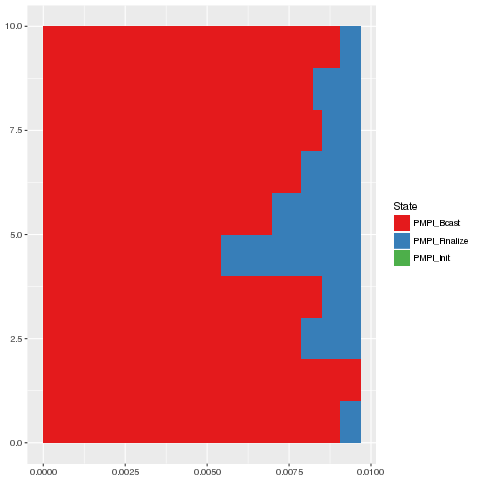

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0 0.00211 0.00317 0.0038 ...
 $ End     : num  0 0.00211 0.00317 0.0038 0.0038 ...
 $ Duration: num  0 0.002113 0.001057 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


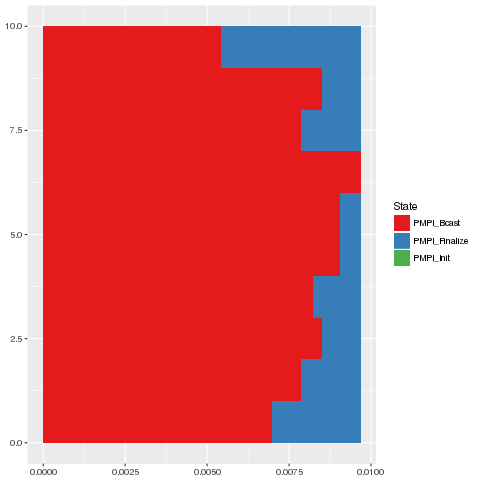

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0 0.00149 0.00476 0.00585 ...
 $ End     : num  0 0.00149 0.00476 0.00585 0.00748 ...
 $ Duration: num  0 0.00149 0.00328 0.00108 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


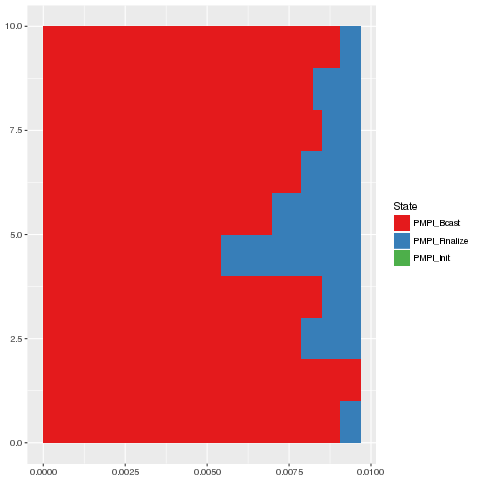

T_curr :  0
D_curr :  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Dprime :  0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
total execution time :  0

returning: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

  || RESULTS || 

TO EXPLORE : 
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002286 0.003332 0.003958 ...
 $ End     : num  0 0.00229 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.00209 0.001046 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


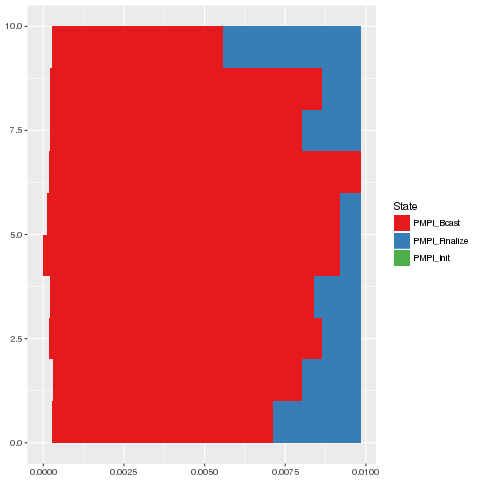

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000329 0.0017 0.004917 0.005908 ...
 $ End     : num  0 0.0017 0.00492 0.00591 0.00742 ...
 $ Duration: num  0 0.001371 0.003217 0.000991 0.001515 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


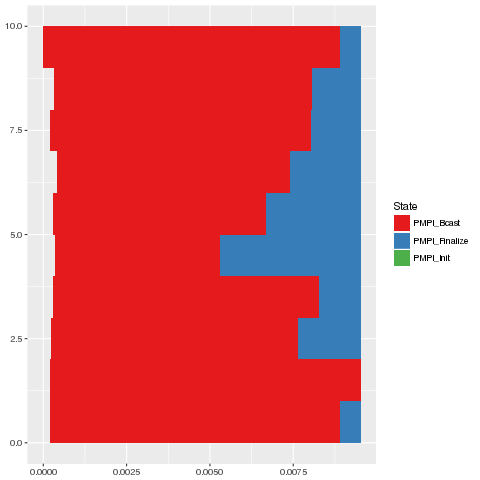

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.00214 0.002968 0.003594 ...
 $ End     : num  0 0.00214 0.00297 0.00359 0.00359 ...
 $ Duration: num  0 0.001923 0.000828 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


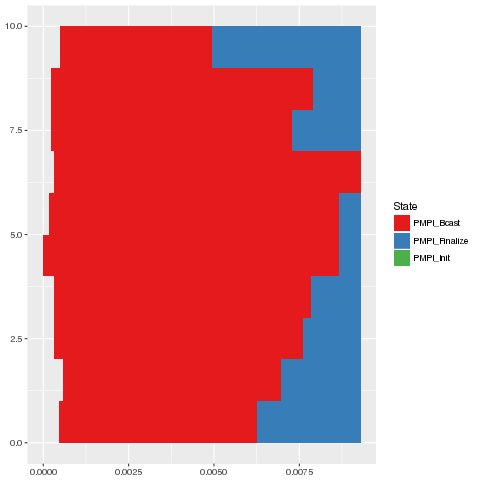

T_curr :  5
D_curr :  0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
Dprime :  0.0014 0.0021 0.0027 0.0029 0.0038 0.0038 0.0044 0.0024 0.003 0.0
total execution time :  0.0054

returning: 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037

  || RESULTS || 

TO EXPLORE : 
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


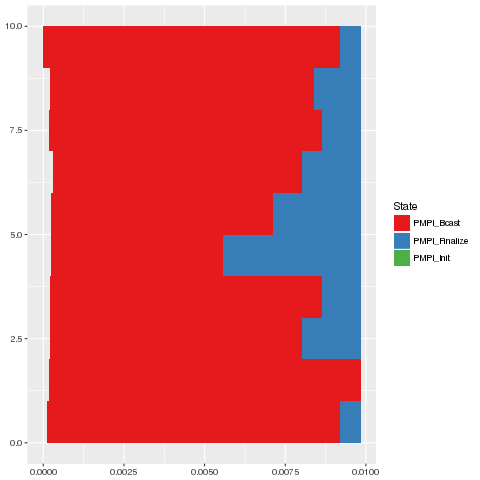

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000238 0.002265 0.003272 0.003897 ...
 $ End     : num  0 0.00227 0.00327 0.0039 0.0039 ...
 $ Duration: num  0 0.002027 0.001007 0.000625 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


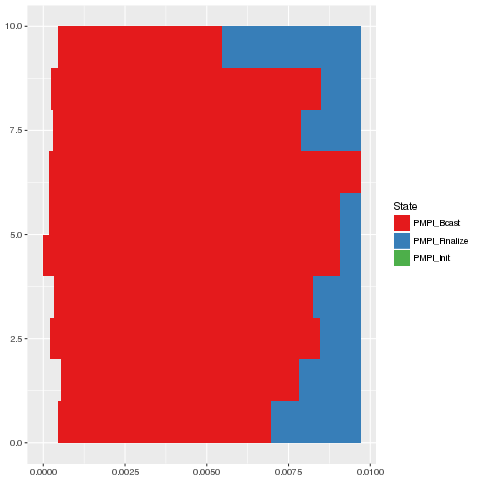

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.0016 0.00486 0.005837 ...
 $ End     : num  0 0.0016 0.00486 0.00584 0.00736 ...
 $ Duration: num  0 0.001355 0.00326 0.000977 0.00152 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


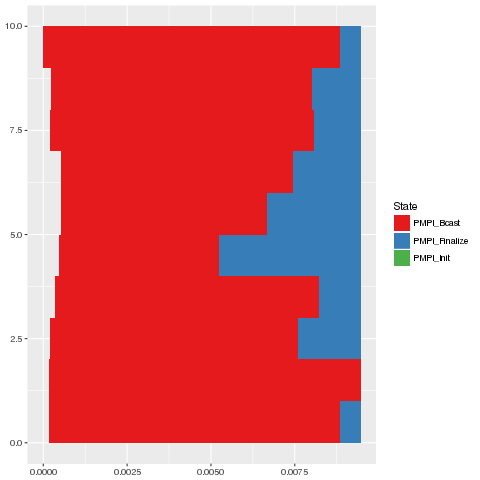

T_curr :  10
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0036 0.0043 0.0024 0.003 0.0 0.0015 0.0022 0.0029 0.0028 0.0036
total execution time :  0.011

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


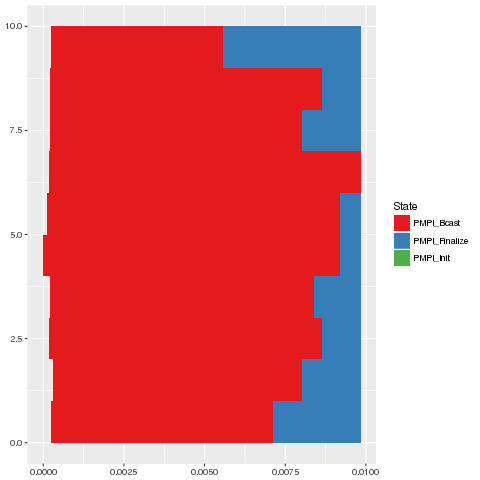

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000224 0.001622 0.004923 0.005911 ...
 $ End     : num  0 0.00162 0.00492 0.00591 0.00743 ...
 $ Duration: num  0 0.001398 0.003301 0.000988 0.001515 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


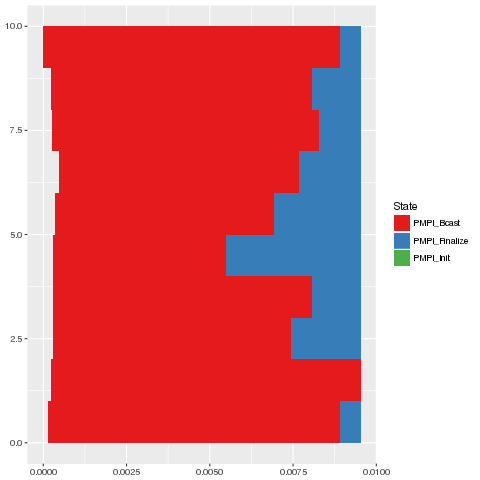

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000266 0.002329 0.003343 0.003969 ...
 $ End     : num  0 0.00233 0.00334 0.00397 0.00397 ...
 $ Duration: num  0 0.002063 0.001014 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


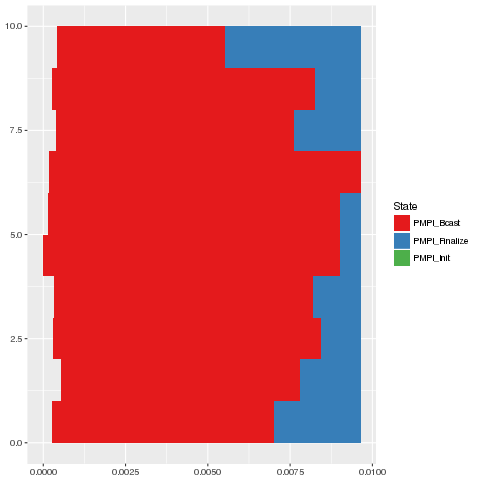

T_curr :  15
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0015 0.0023 0.0029 0.0027 0.0035 0.0035 0.0041 0.0021 0.0028 0.0
total execution time :  0.0166

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


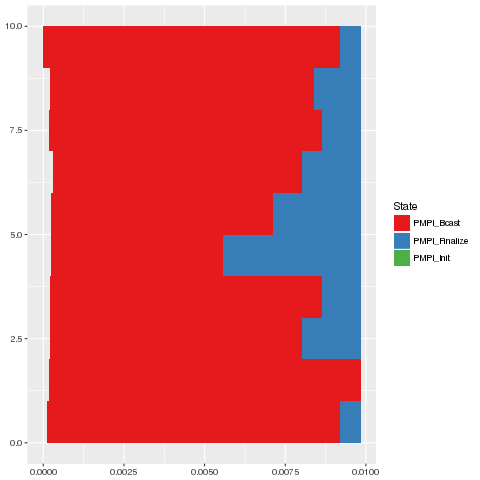

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000287 0.00231 0.003369 0.003995 ...
 $ End     : num  0 0.00231 0.00337 0.004 0.004 ...
 $ Duration: num  0 0.002023 0.001059 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


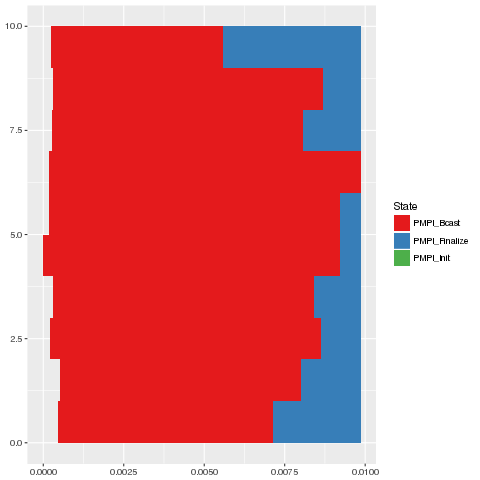

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.001601 0.004914 0.005865 ...
 $ End     : num  0 0.0016 0.00491 0.00587 0.00737 ...
 $ Duration: num  0 0.001356 0.003313 0.000951 0.001504 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


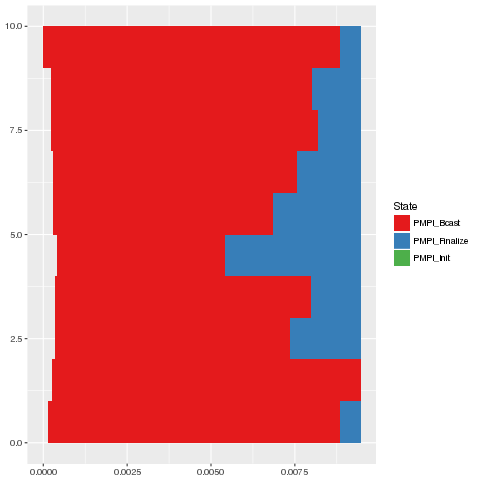

T_curr :  20
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0034 0.0041 0.0019 0.0026 0.0 0.0015 0.0022 0.0028 0.0026 0.0034
total execution time :  0.0222

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


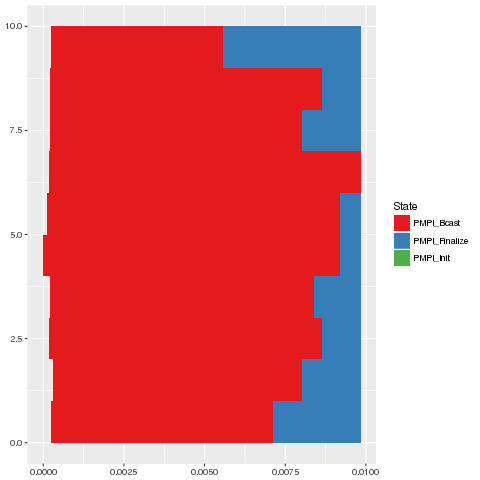

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000273 0.001715 0.004999 0.006048 ...
 $ End     : num  0 0.00171 0.005 0.00605 0.00762 ...
 $ Duration: num  0 0.00144 0.00328 0.00105 0.00157 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


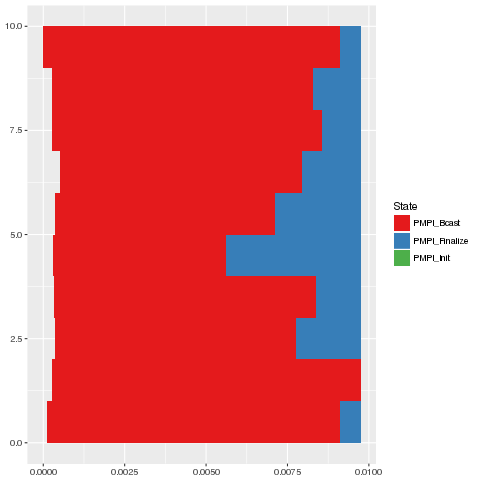

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000308 0.002324 0.003239 0.003906 ...
 $ End     : num  0 0.00232 0.00324 0.00391 0.00391 ...
 $ Duration: num  0 0.002016 0.000915 0.000667 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


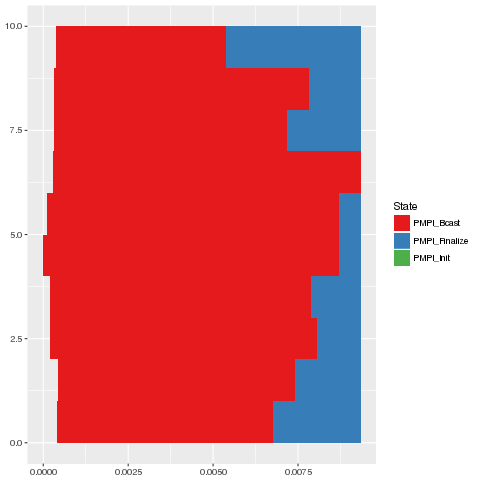

T_curr :  25
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0014 0.002 0.0026 0.0025 0.0033 0.0033 0.0039 0.0018 0.0024 0.0
total execution time :  0.027800000000000002

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


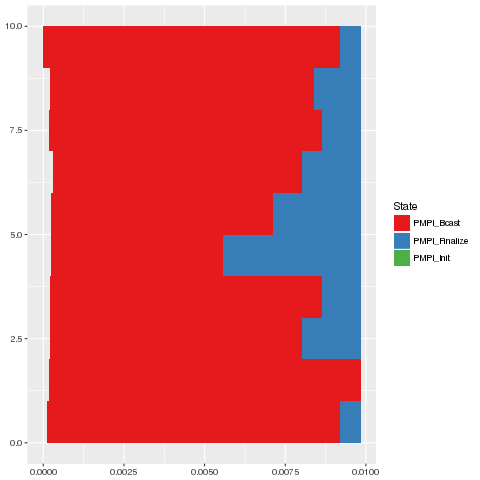

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000273 0.002282 0.00324 0.003866 ...
 $ End     : num  0 0.00228 0.00324 0.00387 0.00387 ...
 $ Duration: num  0 0.002009 0.000958 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


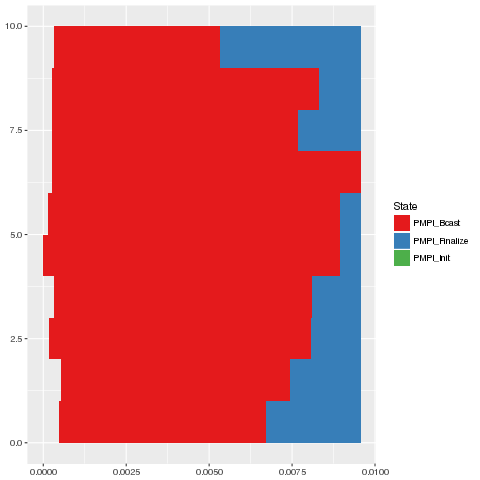

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.00021 0.00159 0.0049 0.00588 ...
 $ End     : num  0 0.00159 0.0049 0.00588 0.00739 ...
 $ Duration: num  0 0.001383 0.003305 0.000978 0.001511 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


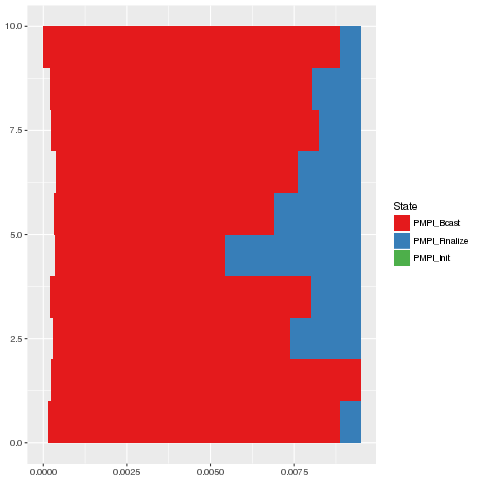

T_curr :  30
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0035 0.0041 0.002 0.0026 0.0 0.0015 0.0022 0.0028 0.0026 0.0035
total execution time :  0.0334

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


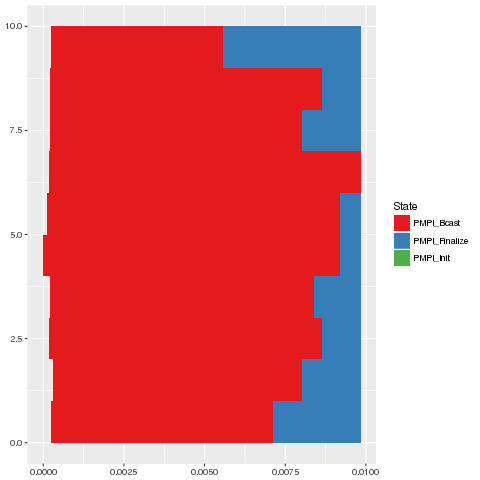

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000301 0.001616 0.004917 0.005914 ...
 $ End     : num  0 0.00162 0.00492 0.00591 0.00744 ...
 $ Duration: num  0 0.001315 0.003301 0.000997 0.001523 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


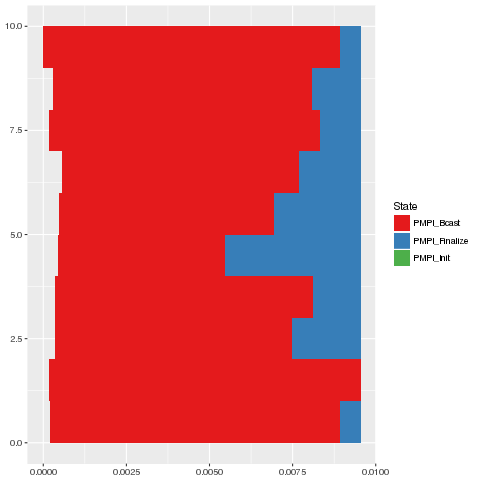

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000238 0.00235 0.003421 0.004047 ...
 $ End     : num  0 0.00235 0.00342 0.00405 0.00405 ...
 $ Duration: num  0 0.002112 0.001071 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


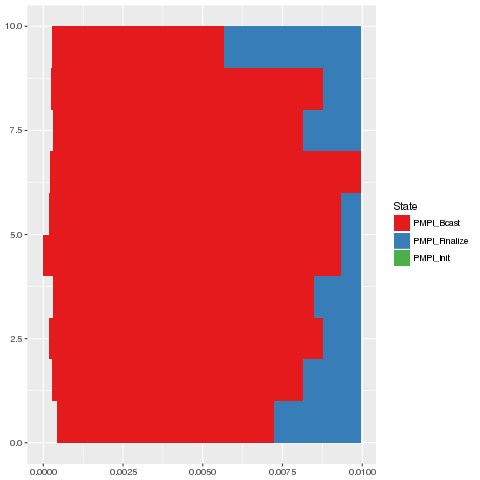

T_curr :  35
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
total execution time :  0.039

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


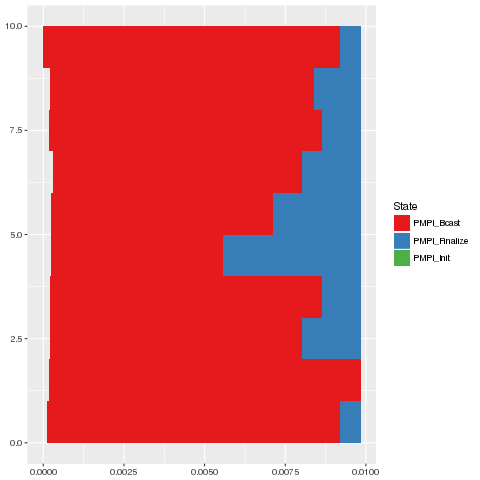

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000273 0.002368 0.003442 0.004068 ...
 $ End     : num  0 0.00237 0.00344 0.00407 0.00407 ...
 $ Duration: num  0 0.002095 0.001074 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


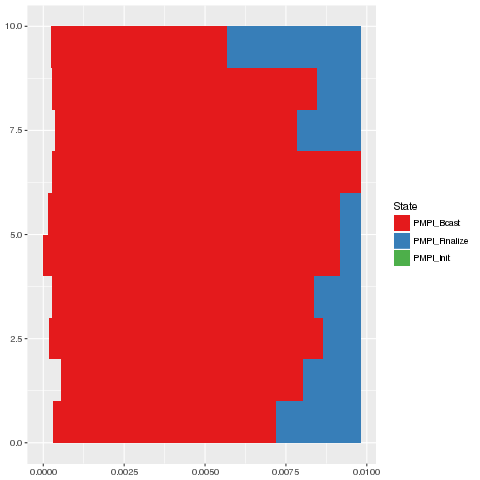

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000287 0.001608 0.004935 0.005864 ...
 $ End     : num  0 0.00161 0.00494 0.00586 0.00737 ...
 $ Duration: num  0 0.001321 0.003327 0.000929 0.001503 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


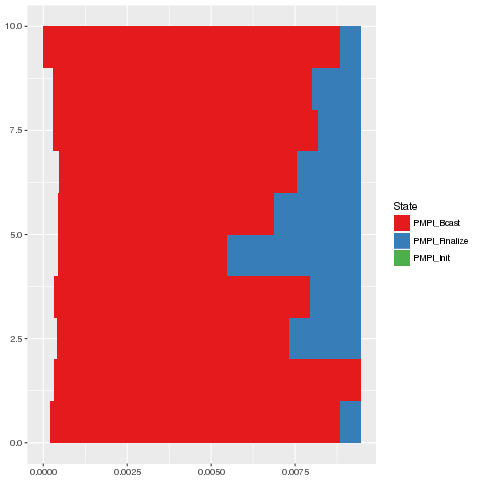

T_curr :  40
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0033 0.0039 0.0018 0.0024 0.0 0.0014 0.002 0.0027 0.0025 0.0033
total execution time :  0.0446

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


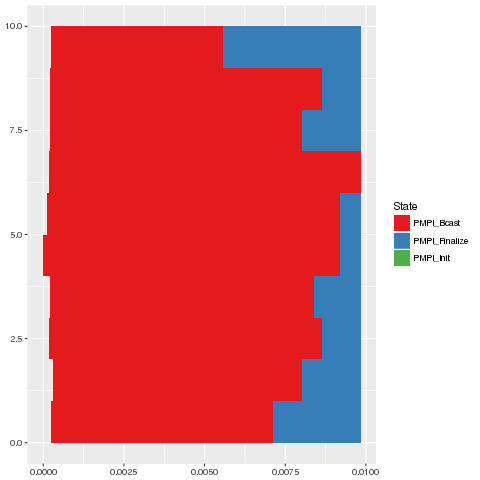

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001591 0.004895 0.005888 ...
 $ End     : num  0 0.00159 0.0049 0.00589 0.00742 ...
 $ Duration: num  0 0.001374 0.003304 0.000993 0.001536 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


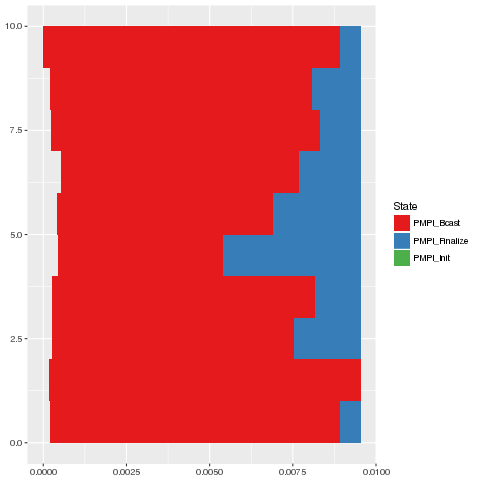

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000329 0.002295 0.003167 0.00387 ...
 $ End     : num  0 0.0023 0.00317 0.00387 0.00387 ...
 $ Duration: num  0 0.001966 0.000872 0.000703 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


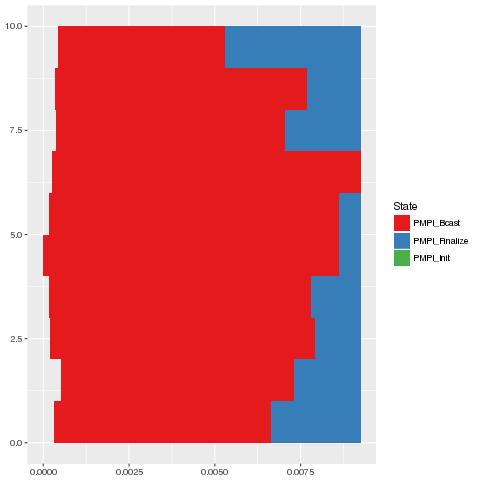

T_curr :  45
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0013 0.002 0.0026 0.0025 0.0033 0.0033 0.0039 0.0018 0.0024 0.0
total execution time :  0.0502

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


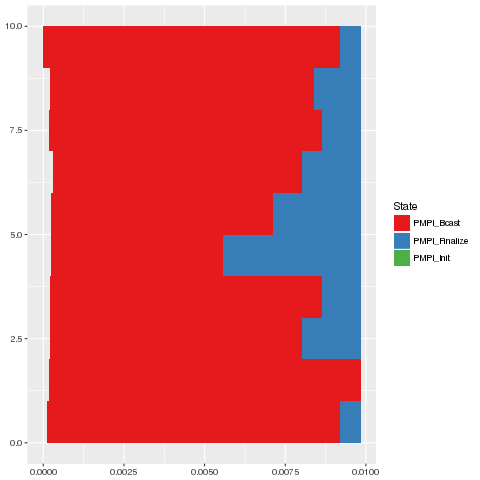

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000203 0.002314 0.003335 0.003961 ...
 $ End     : num  0 0.00231 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002111 0.001021 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


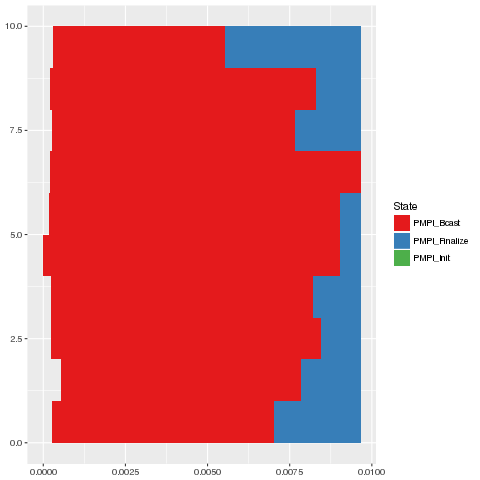

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000189 0.001518 0.004843 0.005769 ...
 $ End     : num  0 0.00152 0.00484 0.00577 0.00727 ...
 $ Duration: num  0 0.001329 0.003325 0.000926 0.001501 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


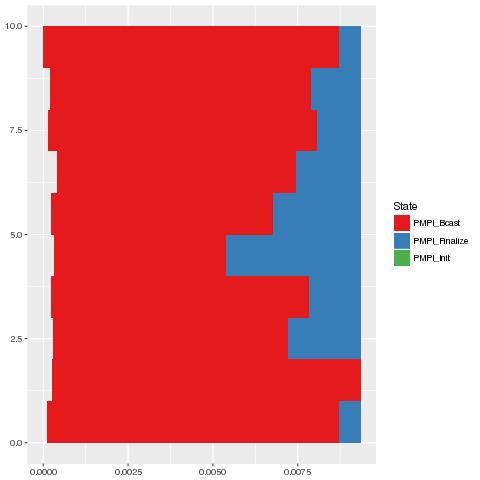

T_curr :  50
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0033 0.004 0.0018 0.0024 0.0 0.0014 0.002 0.0027 0.0025 0.0033
total execution time :  0.0558

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0,

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


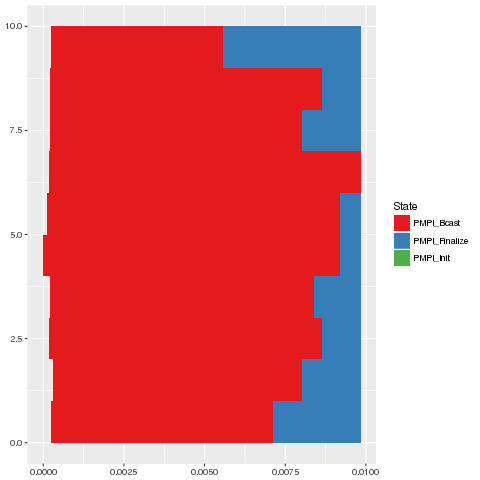

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000371 0.001741 0.005011 0.006106 ...
 $ End     : num  0 0.00174 0.00501 0.00611 0.00773 ...
 $ Duration: num  0 0.00137 0.00327 0.0011 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


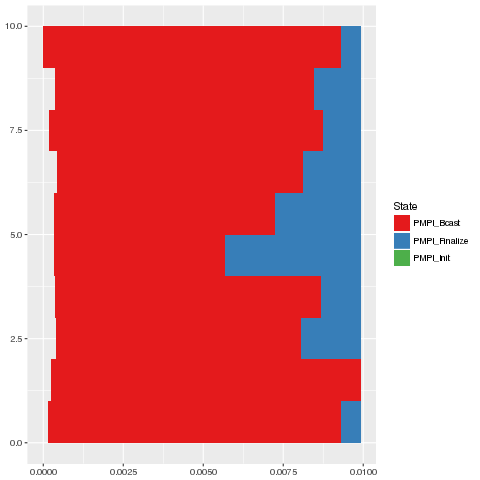

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.00224 0.00317 0.003796 ...
 $ End     : num  0 0.00224 0.00317 0.0038 0.0038 ...
 $ Duration: num  0 0.001995 0.00093 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


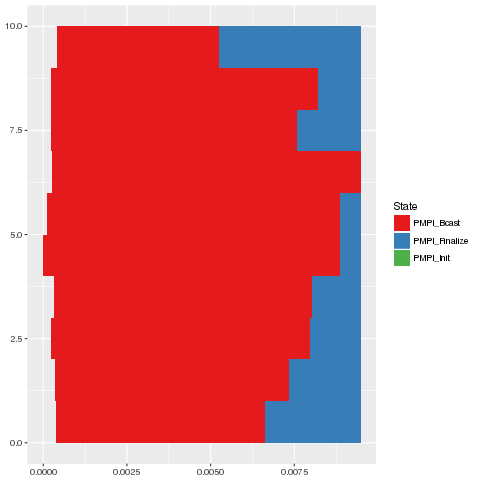

T_curr :  55
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0014 0.0021 0.0028 0.0028 0.0037 0.0037 0.0043 0.0024 0.003 0.0
total execution time :  0.0614

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


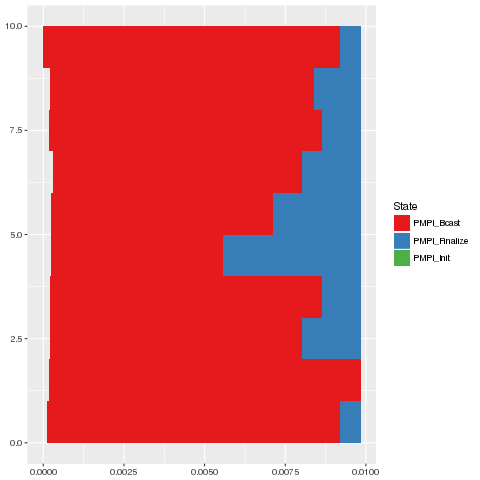

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000203 0.00222 0.003216 0.003842 ...
 $ End     : num  0 0.00222 0.00322 0.00384 0.00384 ...
 $ Duration: num  0 0.002017 0.000996 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


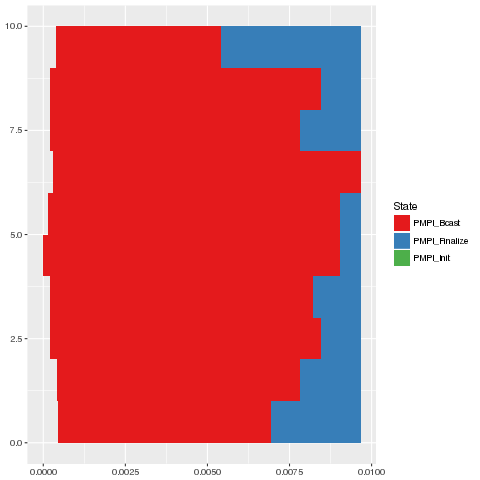

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.001608 0.004916 0.0059 ...
 $ End     : num  0 0.00161 0.00492 0.0059 0.00744 ...
 $ Duration: num  0 0.001363 0.003308 0.000984 0.001539 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


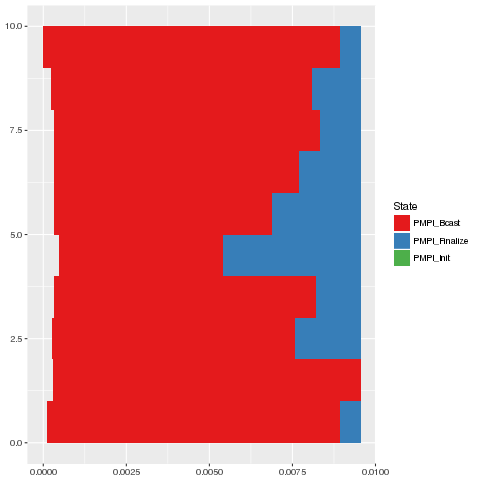

T_curr :  60
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0035 0.0041 0.0022 0.0028 0.0 0.0015 0.0023 0.0029 0.0027 0.0035
total execution time :  0.067

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


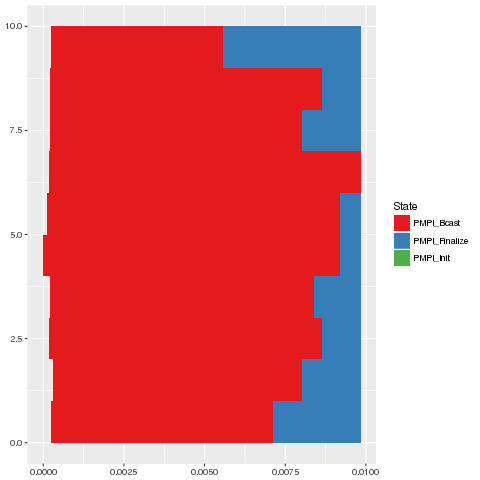

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000364 0.001721 0.005009 0.006054 ...
 $ End     : num  0 0.00172 0.00501 0.00605 0.00765 ...
 $ Duration: num  0 0.00136 0.00329 0.00104 0.0016 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


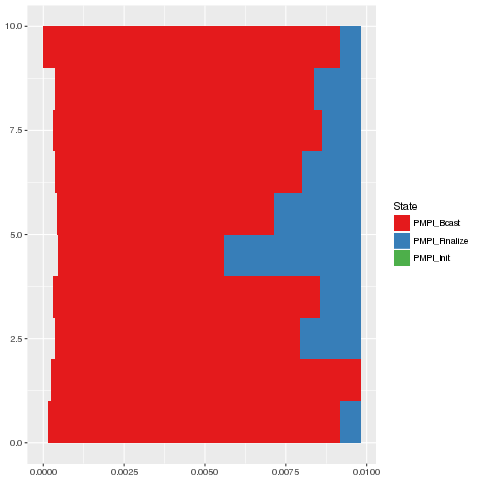

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.002287 0.003247 0.003873 ...
 $ End     : num  0 0.00229 0.00325 0.00387 0.00387 ...
 $ Duration: num  0 0.002042 0.00096 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


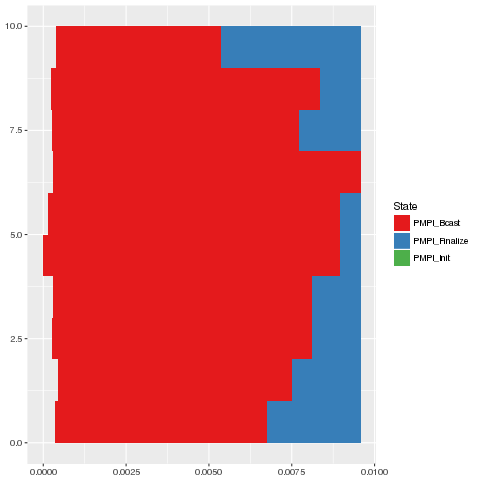

T_curr :  65
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0014 0.0021 0.0027 0.0027 0.0036 0.0036 0.0042 0.0023 0.0029 0.0
total execution time :  0.0726

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


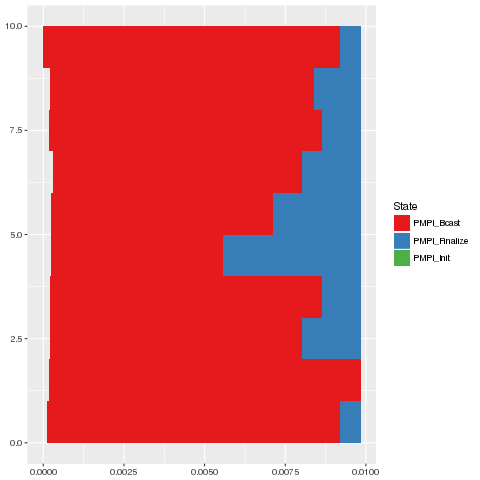

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000357 0.002301 0.003321 0.003947 ...
 $ End     : num  0 0.0023 0.00332 0.00395 0.00395 ...
 $ Duration: num  0 0.001944 0.00102 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


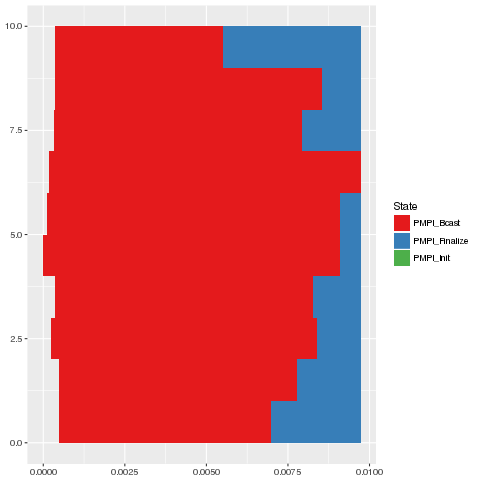

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.001543 0.004854 0.005813 ...
 $ End     : num  0 0.00154 0.00485 0.00581 0.00732 ...
 $ Duration: num  0 0.001298 0.003311 0.000959 0.001506 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


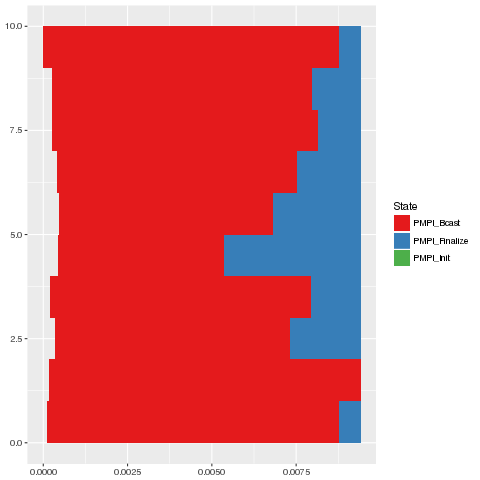

T_curr :  70
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0034 0.004 0.0019 0.0025 0.0 0.0014 0.0021 0.0028 0.0026 0.0034
total execution time :  0.07819999999999999

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


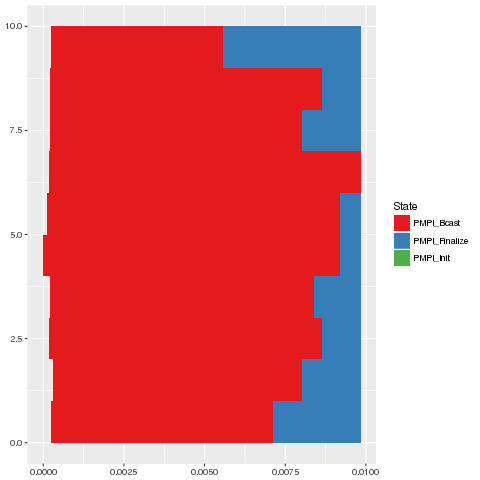

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000273 0.001652 0.004923 0.005914 ...
 $ End     : num  0 0.00165 0.00492 0.00591 0.00745 ...
 $ Duration: num  0 0.001379 0.003271 0.000991 0.00154 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


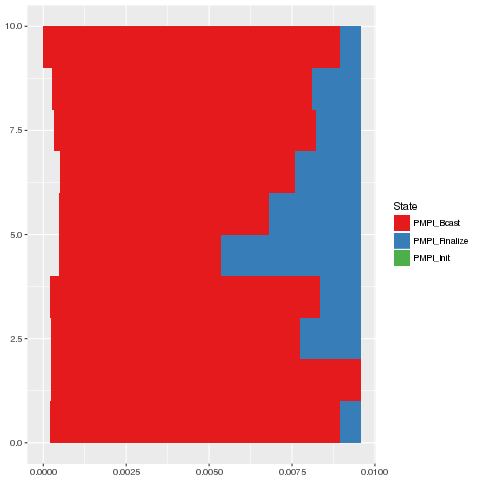

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.00021 0.00232 0.00336 0.00398 ...
 $ End     : num  0 0.00232 0.00336 0.00398 0.00398 ...
 $ Duration: num  0 0.002106 0.00104 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


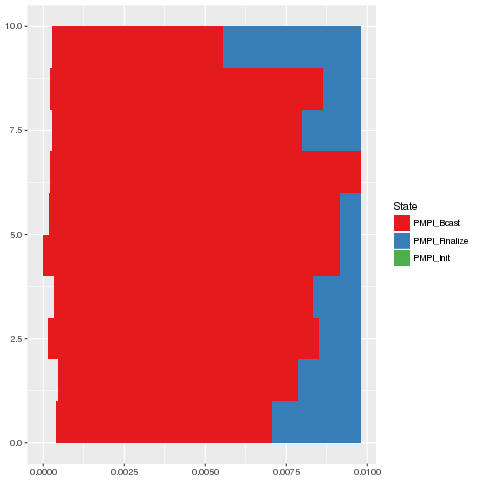

T_curr :  75
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0015 0.0023 0.0029 0.0027 0.0036 0.0036 0.0042 0.0024 0.003 0.0
total execution time :  0.08379999999999999

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.005 0.0043 0.0057 0.0028 0.0047 0.0
		('0.0036

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


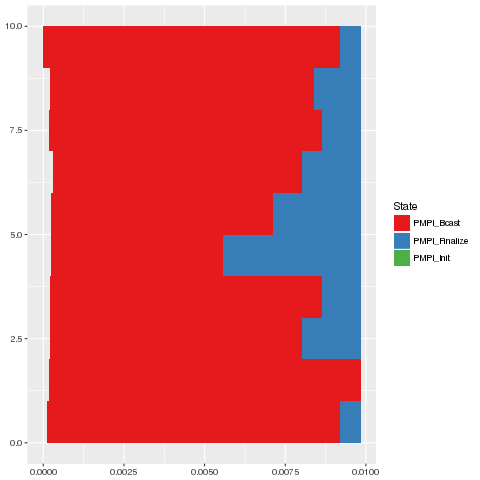

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.00028 0.0024 0.00343 0.00406 ...
 $ End     : num  0 0.0024 0.00343 0.00406 0.00406 ...
 $ Duration: num  0 0.002118 0.001032 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


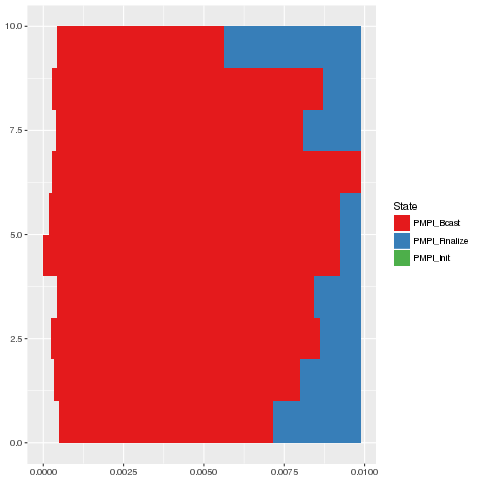

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000364 0.001778 0.005015 0.006139 ...
 $ End     : num  0 0.00178 0.00502 0.00614 0.00778 ...
 $ Duration: num  0 0.00141 0.00324 0.00112 0.00164 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


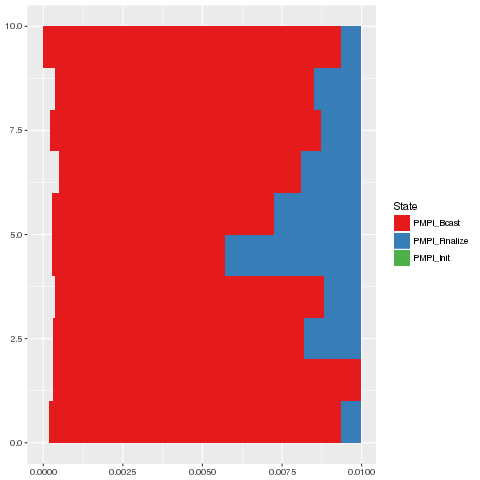

T_curr :  80
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0036 0.0043 0.0025 0.0031 0.0 0.0015 0.0024 0.003 0.0028 0.0036
total execution time :  0.08939999999999998

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.005 0.0043 0.0057 0.0028 0.0047 0.0
		('0.0036 0.0042 0.0023 0.003 0.0 0.0014 0.0021 0.0027 

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


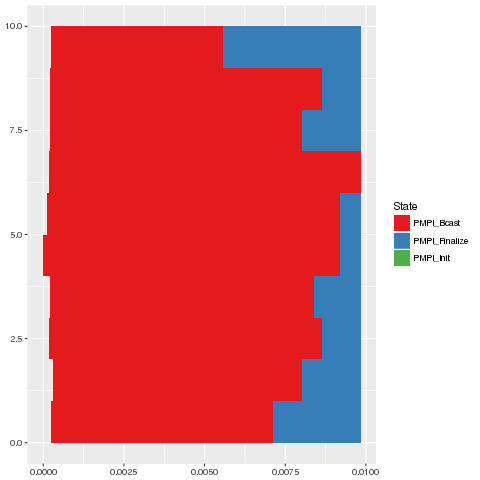

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000238 0.001541 0.004862 0.0058 ...
 $ End     : num  0 0.00154 0.00486 0.0058 0.0073 ...
 $ Duration: num  0 0.001303 0.003321 0.000938 0.001505 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


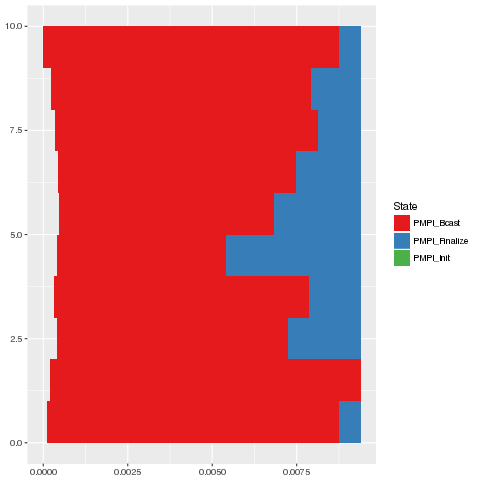

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002261 0.003245 0.003871 ...
 $ End     : num  0 0.00226 0.00325 0.00387 0.00387 ...
 $ Duration: num  0 0.002065 0.000984 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


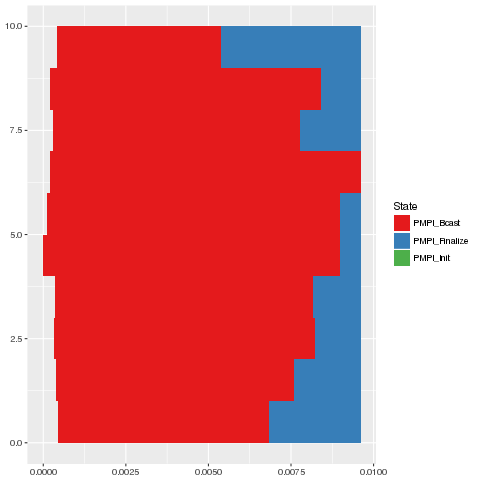

T_curr :  85
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0014 0.0022 0.0028 0.0028 0.0036 0.0036 0.0042 0.0024 0.003 0.0
total execution time :  0.09499999999999997

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.005 0.0043 0.0057 0.0028 0.0047 0.0
		('0.0036 0.0042 0.0023 0.003 0.0 0.0014 0.0021 0.0027 0.0028 0.0036', 2, 1, 0.0053)
	0.0015 0.0024 0

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000217 0.001657 0.004936 0.00601 ...
 $ End     : num  0 0.00166 0.00494 0.00601 0.00764 ...
 $ Duration: num  0 0.00144 0.00328 0.00107 0.00163 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


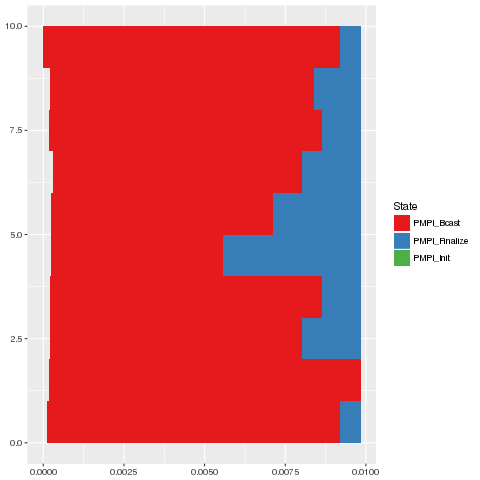

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000245 0.002303 0.003265 0.003892 ...
 $ End     : num  0 0.0023 0.00327 0.00389 0.00389 ...
 $ Duration: num  0 0.002058 0.000962 0.000627 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


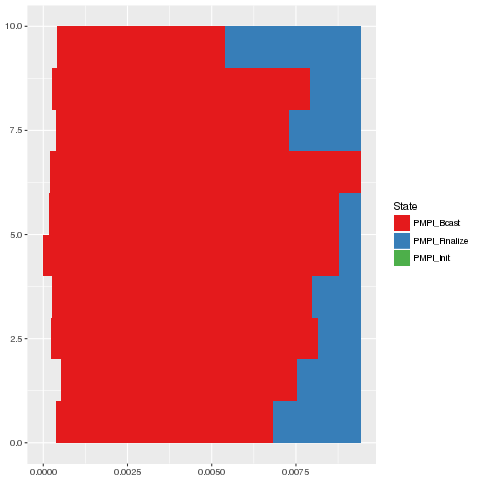

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0 0.00211 0.00317 0.0038 ...
 $ End     : num  0 0.00211 0.00317 0.0038 0.0038 ...
 $ Duration: num  0 0.002113 0.001057 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


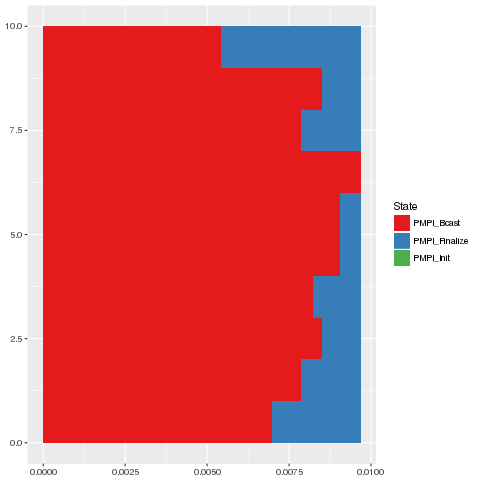

T_curr :  90
D_curr :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
Dprime :  0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
total execution time :  0.10059999999999997

returning: 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

TO EXPLORE : 
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.005 0.0043 0.0057 0.0028 0.0047 0.0
		('0.0036 0.0042 0.0023 0.003 0.0 0.0014 0.0021 0.0027 0.0028 0.0036', 2, 1, 0.0053)
	0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
		('0.0036 0.0042 0.0024 0.0031 0.0 0.0

/home/nezzine/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


'data.frame':	70 obs. of  5 variables:
 $ Rank    : num  8 8 8 8 8 8 8 7 7 7 ...
 $ Start   : num  0 0.000196 0.002283 0.003331 0.003957 ...
 $ End     : num  0 0.00228 0.00333 0.00396 0.00396 ...
 $ Duration: num  0 0.002087 0.001048 0.000626 0 ...
 $ State   : Factor w/ 3 levels "PMPI_Bcast","PMPI_Finalize",..: 3 1 1 1 1 1 2 3 1 1 ...


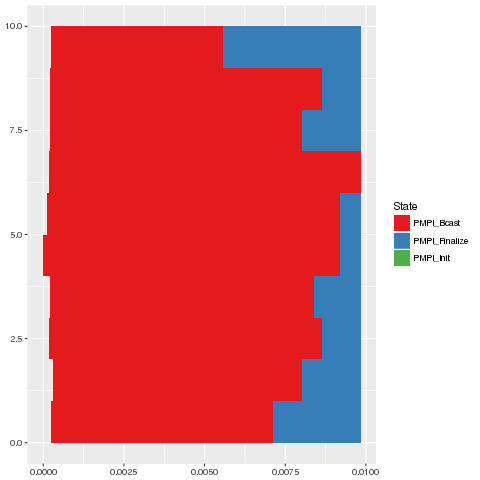

T_curr :  95
D_curr :  0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
Dprime :  0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
total execution time :  0.10619999999999996

returning: 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

TO EXPLORE : 
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037', 1, 0, 0.0054)
5
	0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
		('0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0', 2, 0, 0.0056)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0', 1, 1, 0.0054)
10
	0.0028 0.003 0.0035 0.0043 0.005 0.0043 0.0057 0.0028 0.0047 0.0
		('0.0036 0.0042 0.0023 0.003 0.0 0.0014 0.0021 0.0027 0.0028 0.0036', 2, 1, 0.0053)
	0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
		('0.0036 0.0042 0.0024 0.0031 0.0 0.0

In [43]:
DEBUG = True
# Nbr pcs
NPROCS = 10
    
# Nbr itérations
N = 100

# taille paquet d'itérations
fragment_size = 5

# Precision désirée pour le recollement des trajectoires
precision = 4

gap = 0.0005

# mode de génération de l'état initial à chaque round
mode_opt = ["FIX", "RAND", "RAND_INF", "RAND_SUP"]
mode = mode_opt[2]

catch_me = True

# Lancement de la simulation
simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

#### Publication des résultats sur GitHub : https://github.com/HooBaeBoo/Stage-POLARIS

In [39]:
%%bash -s $experiment_name $site
git add .
git commit -m 'Automatic results update : '"$1"' --- '"$2 "'Fix : GAP'

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)
Changes not staged for commit:
	modified:   ../../../../journal.org

no changes added to commit


#### Fin d'expérience : suppression du job

In [ ]:
#oardel([(jobid,site)])

### Zone Test (à ignorer)

In [ ]:
a = [1, 2 ,3]
b = [2, 3, 4]
math.isclose(a, b, abs_tol = 2)

In [ ]:
tue = 6

In [ ]:
def play(tue):
    tue = tue -1
    return tue


a = play(tue)

while (a > 2):
    print(a)
    a = play(a)